## IRIS Task

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sn

## Helper functions for handling data

In [2]:
name_classes = np.array(["Setosa", "Versicolor", "Virginica"])
name_features = np.array(["Sepal length", "Sepal width", "Petal length", "Petal width"])

def load_data() -> np.array:
    """Load the data from all three classes into on 3D numpy array"""
    class_1_data = np.loadtxt('iris_data/class_1', dtype=np.float32, delimiter=',')  # Setosa
    class_2_data = np.loadtxt('iris_data/class_2', dtype=np.float32, delimiter=',')  # Versicolor
    class_3_data = np.loadtxt('iris_data/class_3', dtype=np.float32, delimiter=',')  # Virginica
    data = np.stack((class_1_data, class_2_data, class_3_data))
    return data

def split_data(data, train_size) -> tuple[np.array, np.array]:
    """Split the data from each class into two chucnks, the first with train_size
    data points. Combine the first chuncks from each class togheter, same for second chunk"""
    splitted_data = np.split(data, [train_size], axis=1)   # Split data from each class
    train_data = np.concatenate(splitted_data[0], axis=0)  # Combine training chunck from each class
    test_data = np.concatenate(splitted_data[1], axis=0)   # Combine test chunck from each class
    return (train_data, test_data)

def extend_data(data) -> np.array:
    """To simplify calculations we extend each sample with a 1 to add the
    constant term w0"""
    return np.concatenate((data, np.ones((data.shape[0], 1))), axis=1)

def generate_labels(train_size) -> tuple[np.array, np.array]:
    """Generate labels for both the training set and test set"""
    T_train = np.concatenate((
        np.tile([1,0,0], (train_size, 1)),
        np.tile([0,1,0], (train_size, 1)),
        np.tile([0,0,1], (train_size, 1)))
    )

    T_test = np.concatenate((
        np.tile([1,0,0], (50 - train_size, 1)),
        np.tile([0,1,0], (50 - train_size, 1)),
        np.tile([0,0,1], (50 - train_size, 1)))
    )

    return T_train, T_test

## Helper functions for training of linear classifier

In [3]:
def g(x, W):
    """Produce a value 0-1 for a given feature vector. Equation 20 on vector form classification compendium"""
    zk = np.matmul(W, x)
    gk = 1 / (1 + np.exp(-zk))
    return gk

def MSE(X, T, W):
    """Calculate the MSE, taken from equation 19 in classification compendium"""
    mseSum = 0
    for i in range(np.size(X, 0)):
        xk = X[i,:]
        tk = T[i,:]
        gk = g(xk, W)
        
        mseSum += (1/2)* np.linalg.norm((gk - tk), ord=2)
    
    return mseSum

def grad_MSE(X, T, W):
    """Gradient of MSE, taken from equation 22"""
    gradMSESum = np.zeros(W.shape)
    
    for i in range(np.size(X, 0)):
        xk = X[i,:]
        tk = T[i,:]
        gk = g(xk, W)
        
        a = np.multiply((gk - tk), gk)
        b = np.multiply(a, np.ones(3).T - gk)

        gradMSESum += np.outer(b, xk)

    return gradMSESum

def gradient_descent(alpha, X, T, W, max_iterations=1e3):
    """Perform gradient descent for a fixed amount of iterations"""
    iteration = 0
    mse_iter = np.zeros(int(max_iterations))
    while iteration < max_iterations:
        W = W - alpha * grad_MSE(X, T, W)
        mse_iter[iteration] = MSE(X, T, W)
        iteration += 1
        # print(f"Iteration: {iterations:06}, MSE: {MSE(X, T, W):.2f}, |∇MSE|: {np.linalg.norm(grad_MSE(X, T, W), ord='fro'):.4f}")

    return (W, mse_iter)

## Helper functions for verification of model

In [4]:

def generate_conf_matrix(X, T, W):
    """Generate a confusion matrix for extended data X with labels T when 
    using a linear model with extend matrix W"""
    # 0-axis / y-axis: true class
    # 1-axis / x-axis: predicted class
    conf_matrix = np.zeros((3,3))

    for i in range(np.size(X, 0)):
        x = X[i, :]
        t = T[i, :]
        
        true_class = np.argmax(t)
        predicted_class = np.argmax(g(x, W))
        conf_matrix[true_class][predicted_class] += 1
    
    return conf_matrix


def genarate_conf_matrix_figure(conf_matrix, title):
    """Create a plt.Figure representation of the confusion matrix"""
    confusion_fig = plt.figure(figsize = (10,7))
    confusion_fig = sn.heatmap(conf_matrix, annot=True, cmap="Blues")
    
    error_rate = (np.sum(conf_matrix) - np.trace(conf_matrix)) / np.sum(conf_matrix)
    confusion_fig.set_title(f"{title}. Error rate: {error_rate*100:.1f}%")


    confusion_fig.set_ylabel("True class")
    confusion_fig.set_xlabel("Predicted class")

    confusion_fig.set_xticklabels(name_classes)
    confusion_fig.set_yticklabels(name_classes)
    return confusion_fig

### Test different step lengths

RESULT: alpha: 0.1 MSE: 045.00 |∇MSE|: 0.0002
RESULT: alpha: 0.01 MSE: 016.99 |∇MSE|: 3.3261
RESULT: alpha: 0.001 MSE: 021.25 |∇MSE|: 1.4009
RESULT: alpha: 0.0001 MSE: 027.16 |∇MSE|: 6.1463
RESULT: alpha: 1e-05 MSE: 034.83 |∇MSE|: 15.8177


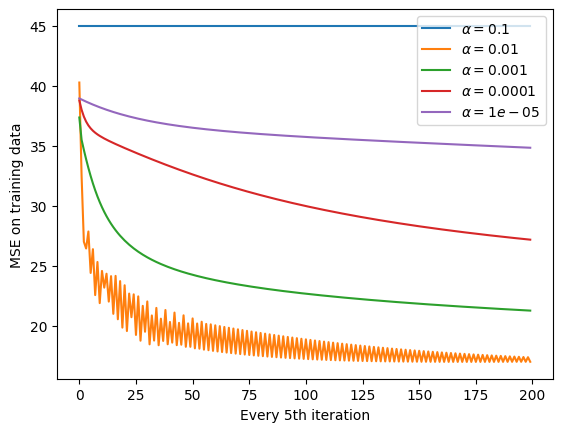

In [5]:
# Task 1.1a, 1.1b

train_size = 30

X_train_raw, X_test_raw = split_data(load_data(), train_size)
X_train, X_test = extend_data(X_train_raw), extend_data(X_test_raw)


alphas = [1e-1, 1e-2, 1e-3, 1e-4, 1e-5]

plt.figure()
for alpha in alphas:
    # W is 3x4 and w0 is 3x1, together we get w W 3x5 ([W w0])
    W = np.zeros((3,5))

    T_train, T_test = generate_labels(train_size)
    W, mse_iter = gradient_descent(alpha=alpha, X=X_train, T=T_train, W=W)
    print(f"RESULT: alpha: {alpha} MSE: {MSE(X_train, T_train, W):06.2f} |∇MSE|: {np.linalg.norm(grad_MSE(X_train, T_train, W), ord='fro'):.4f}")
    plt.plot(mse_iter[::5], label=rf"$\alpha={alpha}$")

plt.xlabel("Every 5th iteration")
plt.ylabel("MSE on training data")
plt.legend()
plt.show()

### Use the first 30 samples for training and the last  20 samples for testing

Shape of raw train data (90, 4)
Shape of raw test data (60, 4)
Shape of extended train data (90, 5)
Shape of extended test data (60, 5)
RESULT: MSE: 016.99 |∇MSE|: 3.3261


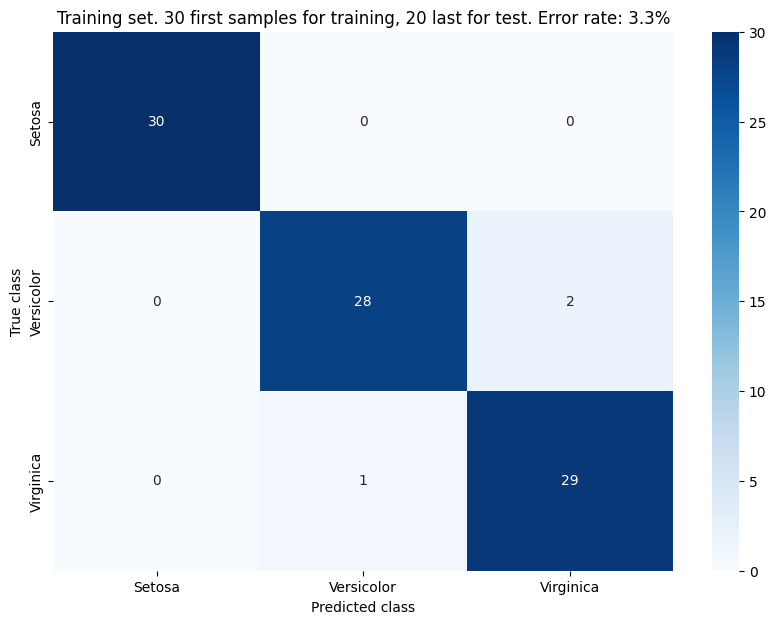

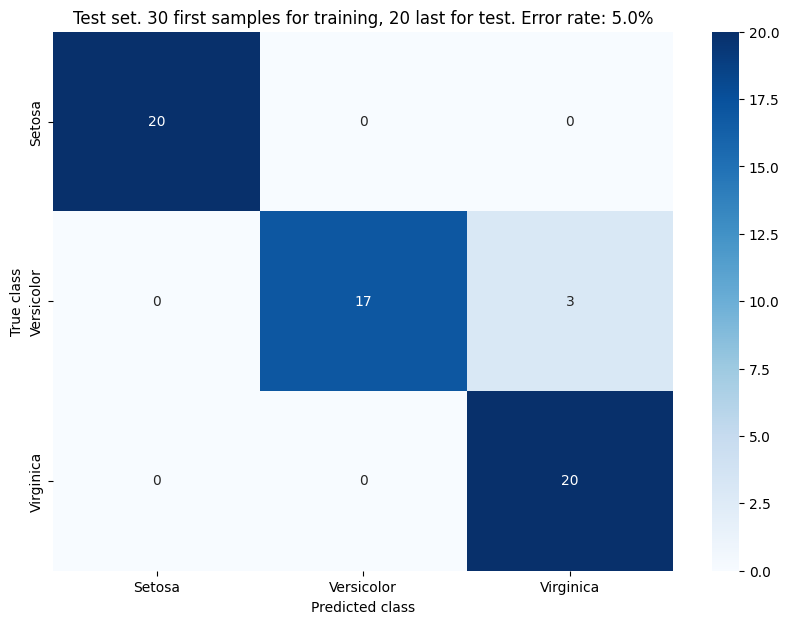

In [6]:
# Task 1.1a, 1.1b

train_size = 30

X_train_raw, X_test_raw = split_data(load_data(), train_size)
print(f"Shape of raw train data {X_train_raw.shape}")
print(f"Shape of raw test data {X_test_raw.shape}")

X_train, X_test = extend_data(X_train_raw), extend_data(X_test_raw)
print(f"Shape of extended train data {X_train.shape}")
print(f"Shape of extended test data {X_test.shape}")


# W is 3x4 and w0 is 3x1, together we get w W 3x5 ([W w0])
W = np.zeros((3,5))

T_train, T_test = generate_labels(train_size)
W, _ = gradient_descent(alpha=0.01, X=X_train, T=T_train, W=W)
print(f"RESULT: MSE: {MSE(X_train, T_train, W):06.2f} |∇MSE|: {np.linalg.norm(grad_MSE(X_train, T_train, W), ord='fro'):.4f}")

# Task 1.1c
conf_matrix_train = generate_conf_matrix(X_train, T_train, W)
fig_train = genarate_conf_matrix_figure(conf_matrix_train, "Training set. 30 first samples for training, 20 last for test")

conf_matrix_test = generate_conf_matrix(X_test, T_test, W)
fig_test = genarate_conf_matrix_figure(conf_matrix_test, "Test set. 30 first samples for training, 20 last for test")

plt.show()

### Use the last 30 samples for training and the first 20 samples for testing

Shape of raw train data (90, 4)
Shape of raw test data (60, 4)
Shape of extended train data (90, 5)
Shape of extended test data (60, 5)
RESULT: MSE: 016.57 |∇MSE|: 10.9546


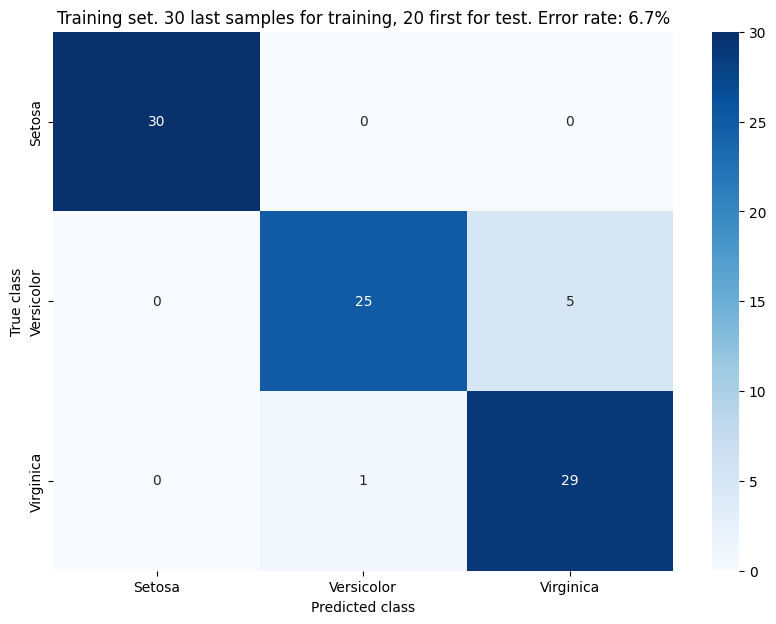

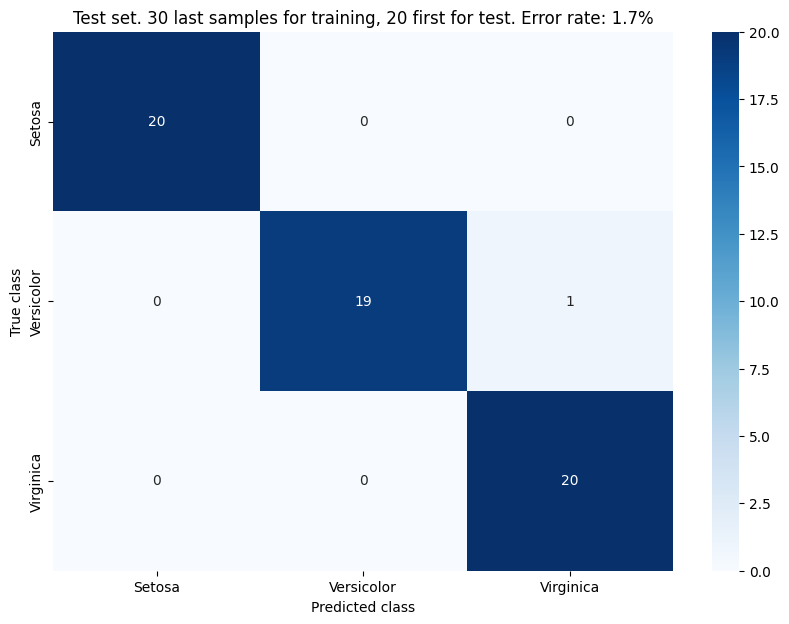

In [7]:
# Task 1.1d, training part

train_size = 30

# Flip the data in each class
reversed_data = np.flip(load_data(), axis=1)

X_train_raw, X_test_raw = split_data(reversed_data, train_size)
print(f"Shape of raw train data {X_train_raw.shape}")
print(f"Shape of raw test data {X_test_raw.shape}")

X_train, X_test = extend_data(X_train_raw), extend_data(X_test_raw)
print(f"Shape of extended train data {X_train.shape}")
print(f"Shape of extended test data {X_test.shape}")

# W is 3x4 and w0 is 3x1, together we get w W 3x5 ([W w0])
# Initialize a W matrix
W = np.zeros((3,5))

T_train, T_test = generate_labels(train_size)
W, _ = gradient_descent(alpha=0.01, X=X_train, T=T_train, W=W)
print(f"RESULT: MSE: {MSE(X_train, T_train, W):06.2f} |∇MSE|: {np.linalg.norm(grad_MSE(X_train, T_train, W), ord='fro'):.4f}")

# Task 1.1d, data illustration

conf_matrix_train = generate_conf_matrix(X_train, T_train, W)
fig_train = genarate_conf_matrix_figure(conf_matrix_train, "Training set. 30 last samples for training, 20 first for test")

conf_matrix_test = generate_conf_matrix(X_test, T_test, W)
fig_test = genarate_conf_matrix_figure(conf_matrix_test, "Test set. 30 last samples for training, 20 first for test")

plt.show()

## Produce historgrams for each feature and class

Measure of overlap in each feature: [('Sepal length', 3.987654666370152), ('Sepal width', 15.66666564239624), ('Petal length', 0.390692127705899), ('Petal width', 1.5277776563609162)]
Feature with largest overlap is: Sepal width


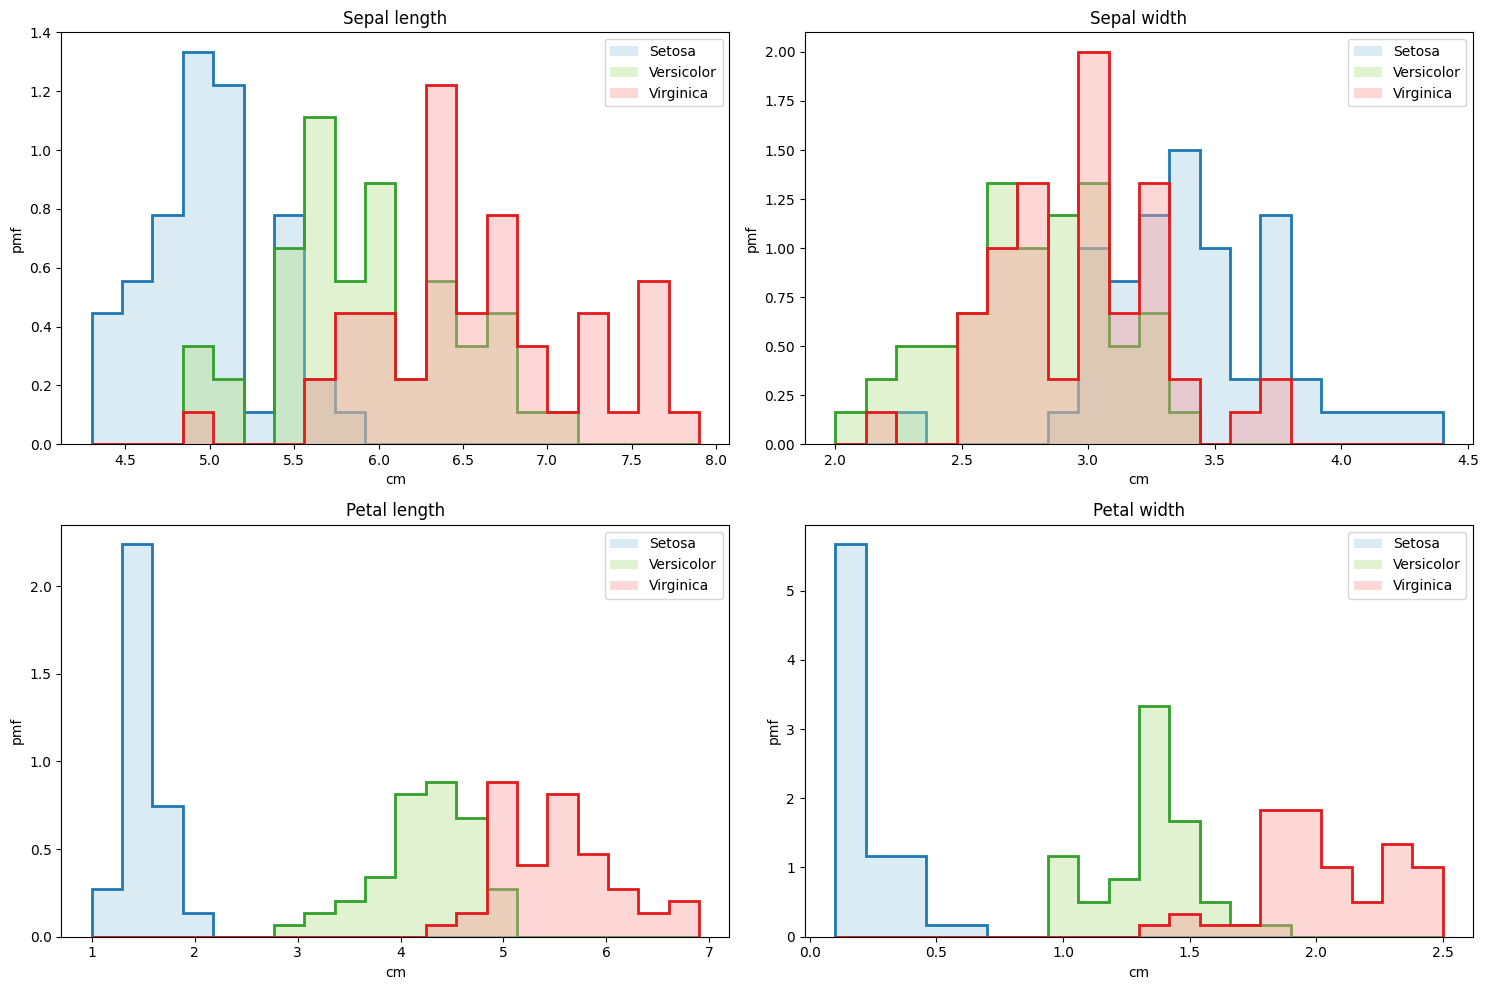

In [122]:
# Task 1.2a, data visualization
data = load_data()

hists = [[], [], []]

fig, axs = plt.subplots(2, 2, figsize=(15, 10))
axs = axs.flatten()

feats_min = np.min(data, axis=(0, 1))
feats_max = np.max(data, axis=(0, 1))

for feat in range(4):
    for cls in range(3):
        feature = data[cls][:, feat]
        counts, bins = np.histogram(feature, bins=20, range=(feats_min[feat], feats_max[feat]), density=True)
        hists[cls].append({"counts": counts, "bins": bins})

        axs[feat].stairs(counts, bins, label=name_classes[cls], fill=True, alpha=0.4, color=plt.cm.Paired.colors[2*cls])
        axs[feat].stairs(counts, bins, fill=False, linewidth=2, color=plt.cm.Paired.colors[2*cls+1])


    axs[feat].legend()
    axs[feat].set_title(name_features[feat])
    axs[feat].set_xlabel("cm")
    axs[feat].set_ylabel("pmf")


fig.tight_layout()

# Calculate thre overlap between the features. As all of the histograms for a feature class have the
# same bins and have been normalized, one possible measure of overlap can be obtained from
#  multiplying the histograms
overlap_feat = []
for feat in range(4):
    overlap_0_1 = np.sum(hists[0][feat]["counts"] * hists[1][feat]["counts"])
    overlap_0_2 = np.sum(hists[0][feat]["counts"] * hists[2][feat]["counts"])
    overlap_1_2 = np.sum(hists[1][feat]["counts"] * hists[2][feat]["counts"])
    overlap_feat.append(overlap_0_1 + overlap_0_2 + overlap_1_2)

print(f"Measure of overlap in each feature: {list(zip(name_features, overlap_feat))}")
print(f"Feature with largest overlap is: {name_features[np.argmax(overlap_feat)]}")

Shape of raw train data with one less feature (90, 3)
Shape of raw test data with one less feature (60, 3)
Shape of extended train data (90, 4)
Shape of extended test data (60, 4)
RESULT: MSE: 018.80 |∇MSE|: 14.0193


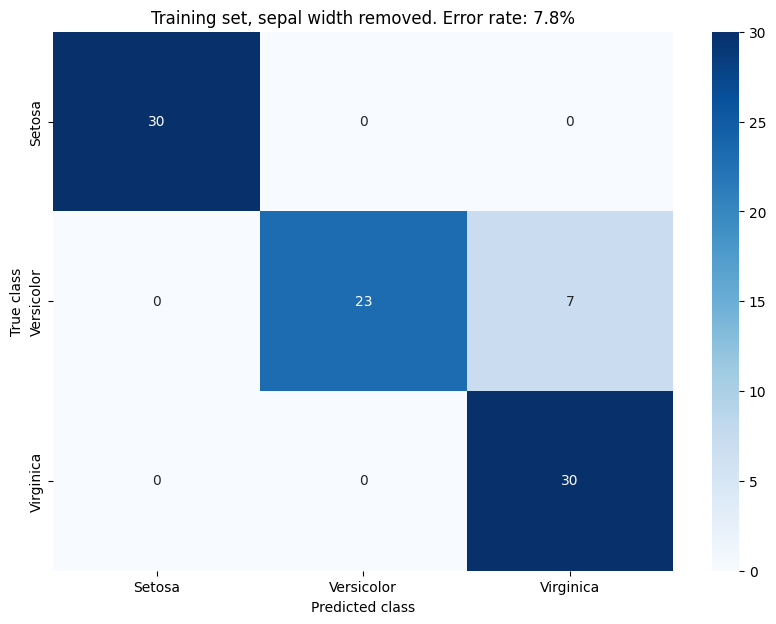

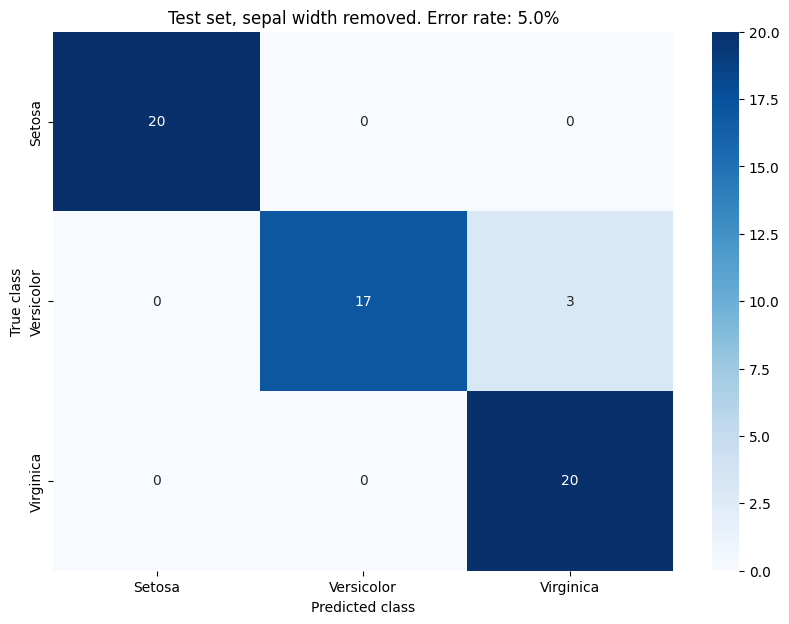

In [9]:
# Task 1.2a, remove sepal width

train_size = 30

X_train_raw, X_test_raw = split_data(load_data(), train_size)

# Remove Sepal width as a feature
X_train = np.delete(X_train_raw, obj=1, axis=1)
X_test = np.delete(X_test_raw, obj=1, axis=1)

print(f"Shape of raw train data with one less feature {X_train.shape}")
print(f"Shape of raw test data with one less feature {X_test.shape}")

X_train, X_test = extend_data(X_train), extend_data(X_test)
print(f"Shape of extended train data {X_train.shape}")
print(f"Shape of extended test data {X_test.shape}")


W = np.zeros((3,4))

T_train, T_test = generate_labels(train_size)
W, _ = gradient_descent(alpha=0.01, X=X_train, T=T_train, W=W)
print(f"RESULT: MSE: {MSE(X_train, T_train, W):06.2f} |∇MSE|: {np.linalg.norm(grad_MSE(X_train, T_train, W), ord='fro'):.4f}")

# Illustrate data
conf_matrix_train = generate_conf_matrix(X_train, T_train, W)
fig_train = genarate_conf_matrix_figure(conf_matrix_train, "Training set, sepal width removed")

conf_matrix_test = generate_conf_matrix(X_test, T_test, W)
fig_test = genarate_conf_matrix_figure(conf_matrix_test, "Test set, sepal width removed")

plt.show()

RESULT: MSE: 021.67 |∇MSE|: 0.3438


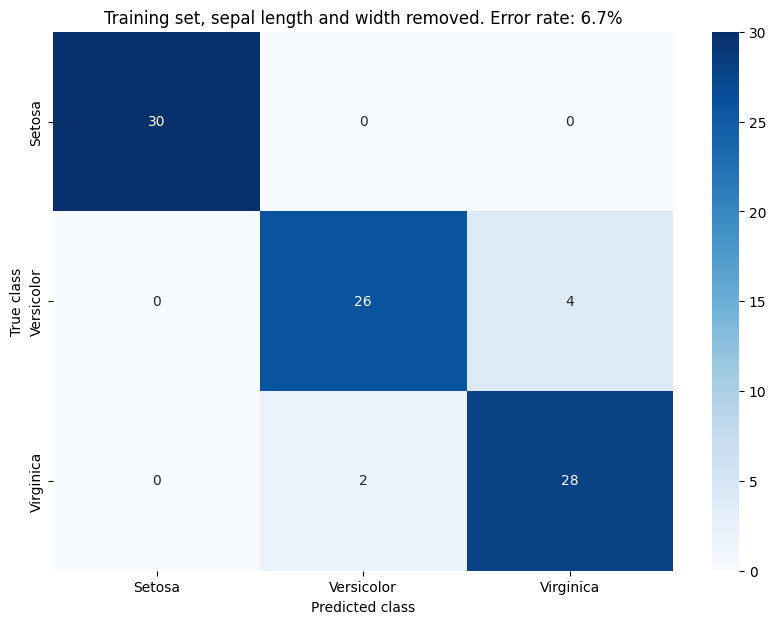

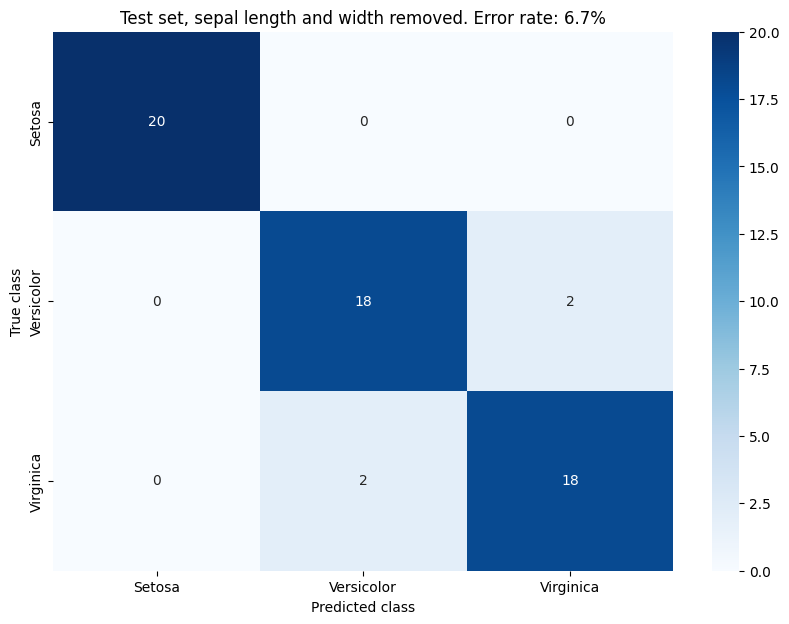

In [10]:
# Task 1.2a, remove sepal width andl length

train_size = 30

X_train_raw, X_test_raw = split_data(load_data(), train_size)

# Remove sepal length and width as a feature
X_train = np.delete(X_train_raw, obj=[0, 1], axis=1)
X_test = np.delete(X_test_raw, obj=[0, 1], axis=1)

X_train, X_test = extend_data(X_train), extend_data(X_test)

W = np.zeros((3, X_train.shape[1])) 

T_train, T_test = generate_labels(train_size)
W, _ = gradient_descent(alpha=0.01, X=X_train, T=T_train, W=W)
print(f"RESULT: MSE: {MSE(X_train, T_train, W):06.2f} |∇MSE|: {np.linalg.norm(grad_MSE(X_train, T_train, W), ord='fro'):.4f}")

# Illustrate data
conf_matrix_train = generate_conf_matrix(X_train, T_train, W)
fig_train = genarate_conf_matrix_figure(conf_matrix_train, "Training set, sepal length and width removed")

conf_matrix_test = generate_conf_matrix(X_test, T_test, W)
fig_test = genarate_conf_matrix_figure(conf_matrix_test, "Test set, sepal length and width removed")

plt.show()

RESULT: MSE: 022.66 |∇MSE|: 0.3336


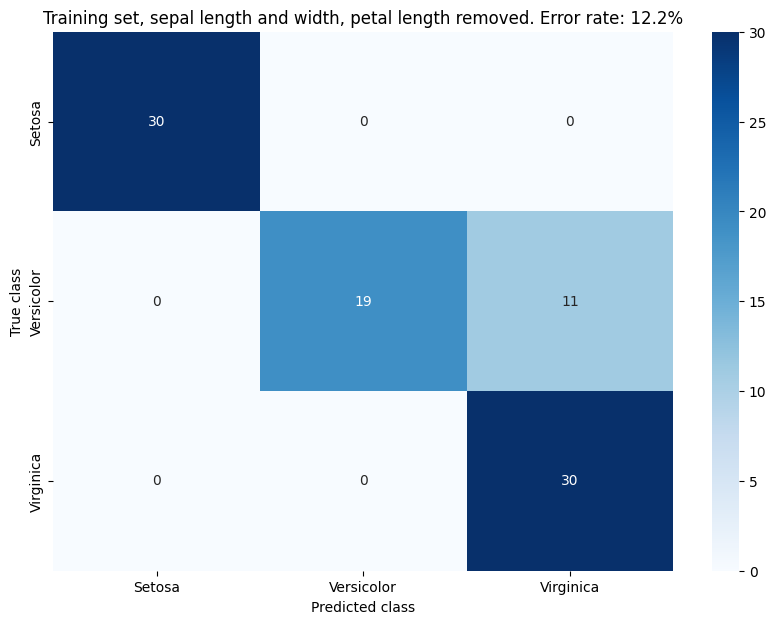

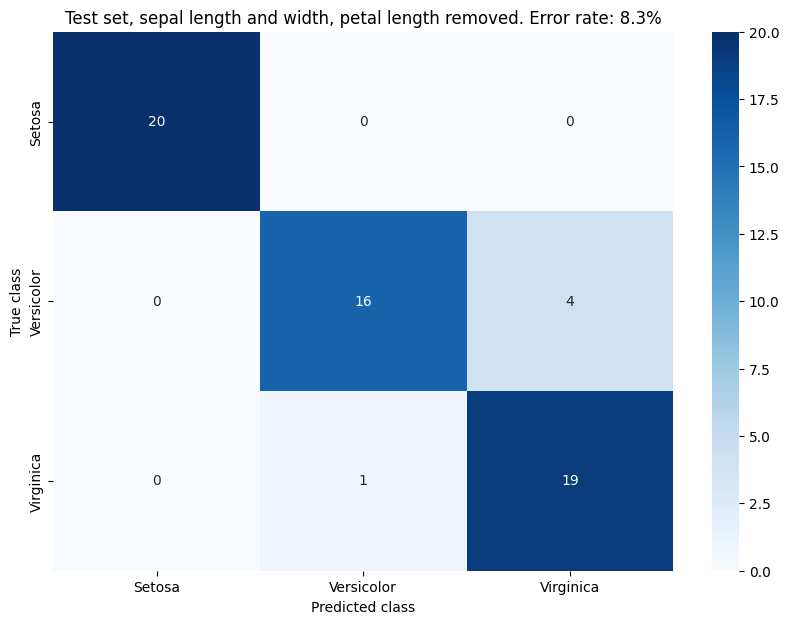

In [11]:
# Task 1.2a, remove sepal width andl length

train_size = 30

X_train_raw, X_test_raw = split_data(load_data(), train_size)

# Remove sepal length and width as a feature
X_train = np.delete(X_train_raw, obj=[0, 1, 2], axis=1)
X_test = np.delete(X_test_raw, obj=[0, 1, 2], axis=1)
X_train, X_test = extend_data(X_train), extend_data(X_test)


W = np.zeros((3, X_train.shape[1])) 

T_train, T_test = generate_labels(train_size)
W, _ = gradient_descent(alpha=0.01, X=X_train, T=T_train, W=W)
print(f"RESULT: MSE: {MSE(X_train, T_train, W):06.2f} |∇MSE|: {np.linalg.norm(grad_MSE(X_train, T_train, W), ord='fro'):.4f}")

# Illustrate data
conf_matrix_train = generate_conf_matrix(X_train, T_train, W)
fig_train = genarate_conf_matrix_figure(conf_matrix_train, "Training set, sepal length and width, petal length removed")

conf_matrix_test = generate_conf_matrix(X_test, T_test, W)
fig_test = genarate_conf_matrix_figure(conf_matrix_test, "Test set, sepal length and width, petal length removed")

plt.show()

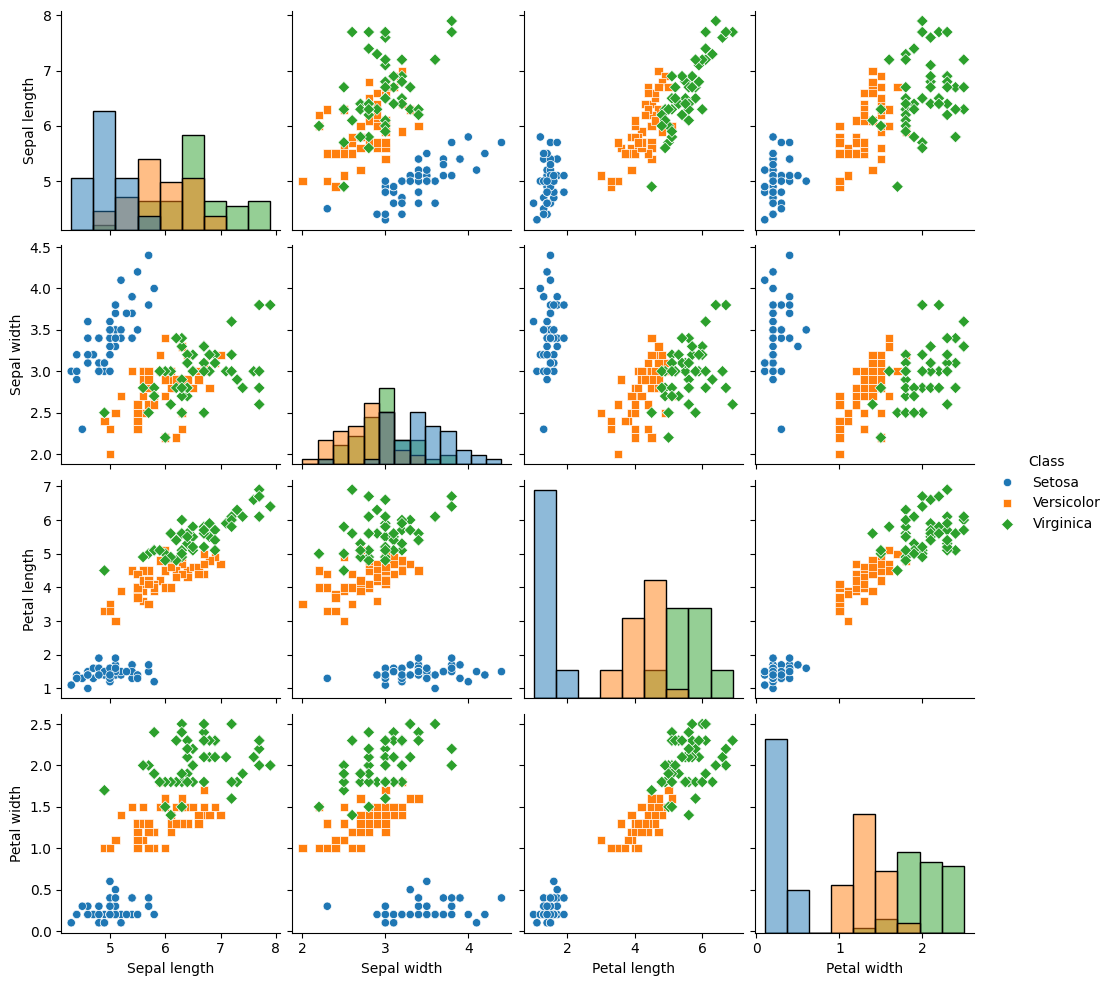

In [12]:
# Not part of the task, consider removing

import pandas as pd

data = load_data()
T, _ = generate_labels(50)
class_labels = name_classes[np.argmax(T, axis=1)]

data_with_class = np.column_stack((data.reshape((150, 4)), class_labels))

df = pd.DataFrame(data.reshape((150, 4)), columns=name_features, dtype=float)
df["Class"] = class_labels
# Pairplot with classes marked
sn.pairplot(df, hue="Class", diag_kind="hist", markers=["o", "s", "D"])

plt.show()